In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
import functions as f
from glob import glob
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import itertools
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from datetime import datetime
import datetime as dt
import preprocessUtils as putils
import masks
import verifications
from ridgeplot import ridgeplot
import joypy
import seaborn as sns
from matplotlib import cm
import climpred
from xclim import sdba
from climpred.options import OPTIONS
import json
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.lines import Line2D  # For custom legend entries
import pickle
import verifications
import masks



2024-05-10 13:23:47.035327: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 13:23:47.103475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 13:23:49.748927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook imp

In [3]:


global dim_order, region_name
dim_order = ['S','M','L','Y','X']
region_name = 'CONUS'

mask = masks.load_mask(region_name)

if region_name == 'CONUS':
    region_mask = masks.load_region_mask(region_name).rename({'latitude':'lat','longitude':'lon'}).isel(time=0)
    CONUS_region_names = {1:'Northeast',2:'Southeast',3:'Midwest',4:'Great Plains',5:'Northwest',6:'Southwest'}

#Mask with np.nan for non-CONUS land values
mask_anom = mask[putils.xarray_varname(mask)][0,:,:].values


In [4]:
permutation_dir = f'Outputs/permutation_tests/mae_rmse_results'

BC,OBS,HYB = verifications.return_experiment_colors_and_names()

Bias-correction (DL_NWP_BC) is black
['EX0', 'EX13']
DL_NWP_BC experiments is None

Observation-driven (DL_OBS) is red
['EX14', 'EX15', 'EX16', 'EX17', 'EX22', 'EX23', 'EX24', 'EX25']
DL_OBS experiments is None

Hybrid (DL_NWP_OBS)
['EX1', 'EX2', 'EX3', 'EX4', 'EX5', 'EX6', 'EX7', 'EX8', 'EX9', 'EX10', 'EX11', 'EX12', 'EX18', 'EX19', 'EX20', 'EX21', 'EX27', 'EX28']
DL_NWP_OBS experiments is None



In [5]:
def unique_channels(file_list):
    all_channels = []
    experiment_names = []
    for file in file_list:
        # break
        #First read the file and get all of the header information
        op = pd.read_csv(file,header=[0])
        col_names = op.columns
        [all_channels.append(i) for i in col_names[1:] if i not in all_channels]
        experiment_names.append(file.split('/')[-1].split('.')[0])
        
    return(all_channels,experiment_names)

def create_pd_dataset(blank_df, file_list):
    for file in file_list:
        # break
        col_name = file.split('/')[-1].split('.')[0]
        #First read the file and get all of the header information
        op = pd.read_csv(file,header=[0])
        col_names = op.columns[1:]
        #Now replace the data in the blank_df
        for i in col_names:
            # break
            blank_df.loc[i,col_name] = op[i][0]
            
    return(blank_df)

def load_ACC_files_make_mean(lead,permuation_dir):
    # Open the file in binary read mode ('rb') and use pickle.load() to load the dictionary
    ACC_path = f'{permuation_dir}/ACC_vals.pkl'
    with open(ACC_path, 'rb') as file:
        loaded_dict = pickle.load(file)
    
    #Take the mean of each experiment
    out_mean = {}
    for ex in list(loaded_dict.keys()):
        # break
        #Get name of each EX
        sp = ex.split('_')
        name = f'{sp[1]}_{sp[3]}'
        out_mean[name] = np.nanmean(loaded_dict[ex])
    
    #rename baseline reforecast
    # Specify the key to be renamed
    old_key = 'MEM_RZSM'
    new_key = 'Baseline_fcst'

    # Create a new key-value pair with the desired key
    out_mean[new_key] = out_mean.pop(old_key)
    out_mean
    
    return(out_mean)


def channel_list_recreate(channels):
    #re-order channels
    rzsm_ = sorted([i for i in channels if 'RZSM' in i])
    element_to_move = 'RZSM_obs_lag-7'
    desired_position = 1  # 3rd position (0-based index)

    rzsm_.remove(element_to_move)  # Remove the element from its current position
    rzsm_.insert(desired_position, element_to_move)
    
    other_channels = [i for i in channels if 'RZSM' not in i]
    
    return(rzsm_+other_channels)

In [6]:
# def take_average_of_each_channel()

In [7]:
# channels,experiment_names = unique_channels(file_list)

In [8]:
#Now make a heatmap by lead
def return_data_by_leads(leads_list):
    intersect = {}

    t_keys = []
    for wk in leads_list:
        all_keys = []
        keep_keys=[]
        for i in ['OBS','HYB']:
            keys_ = list(week_full[f'Wk{wk}'][i].keys())
            all_keys = all_keys + keys_
            t_keys  = t_keys + keys_
        
        intersect[f'Wk{wk}'] = all_keys
    
    '''These are the only keys we will keep with intersection'''
    keep = list(set(intersect['Wk1']).intersection(intersect['Wk1'], intersect['Wk1']))

    '''keep all keys'''
    keep = np.unique(np.array(t_keys))
    
    '''Now grab these values from dictionary '''
    df = pd.DataFrame(columns=keep, index=leads_list)
    
    for wk in leads_list:
        completed = []
        keys_1 = list(week_full[f'Wk{wk}']['OBS'].keys())
        keys_2 = list(week_full[f'Wk{wk}']['HYB'].keys())
        
        for k,v in week_full[f'Wk{wk}']['OBS'].items():
            # break
            '''check if it exists within the HYB'''
            try:
                #if exists, take the average of the 2 values
                df.loc[wk,k] = (week_full[f'Wk{wk}']['OBS'][k]['Value'] + week_full[f'Wk{wk}']['HYB'][k]['Value'])/2
            except KeyError:
                df.loc[wk,k] = week_full[f'Wk{wk}']['OBS'][k]['Value']
                
            completed.append(k)

        for wk in leads_list:
            keys_2 = list(week_full[f'Wk{wk}']['HYB'].keys())
            
            for k,v in week_full[f'Wk{wk}']['HYB'].items():
                # break
                if k in completed:
                    pass
                else:
                    df.loc[wk,k] = week_full[f'Wk{wk}']['HYB'][k]['Value']

                    
    # Sort the first row in descending order
    # sorted_cols = df.iloc[0].sort_values(ascending=False).index
    
    # Reorder the DataFrame columns
    # df = df[sorted_cols]
    
    # Sort the DataFrame by the values of the first row
    # df = df.sort_values(by=df.index[0], axis=1, ascending=False)
    
    # Drop columns with missing values 
    
    # df = df.dropna(axis=1)
    return(df)


In [9]:

#MAE only
metric = 'mae'

week_full = {}

leads_list=[1,2,3,4]

for lead in leads_list:
    with open(f'{permutation_dir}/Wk{lead}_{metric}_vals.pkl', 'rb') as file:
        op = pickle.load(file)

    for model_type in op.keys():
        for channel in op[model_type].keys():
            # break
            op[model_type][channel]['Value'] = op[model_type][channel]['Value'] / op[model_type][channel]['Num_experiments']

    '''Now we have the average for each week across all the different experiments'''
    #Now take the mean across CONUs to get a single value for each one

    for model_type in op.keys():
        for channel in op[model_type].keys():
            # break
            op[model_type][channel]['Value'] = np.nanmean(op[model_type][channel]['Value'])
            
    week_full[f'Wk{lead}'] = op

# START PLOTTING
df_cleaned = return_data_by_leads(leads_list)

# Select the first 7 columns
df = df_cleaned.iloc[:, :].astype(float)

In [10]:
df.columns

Index(['RZSM_obs_lag-1', 'RZSM_obs_lag-14', 'RZSM_obs_lag-21',
       'RZSM_obs_lag-28', 'RZSM_obs_lag-35', 'RZSM_obs_lag-42',
       'RZSM_obs_lag-49', 'RZSM_obs_lag-56', 'RZSM_obs_lag-63',
       'RZSM_obs_lag-7', 'RZSM_obs_lag-70', 'RZSM_obs_lag-77',
       'RZSM_prediction_lead1', 'RZSM_prediction_lead2',
       'RZSM_prediction_lead3', 'RZSM_ref_lead1', 'RZSM_ref_lead2',
       'RZSM_ref_lead3', 'RZSM_ref_lead4', 'diff_temp_obs_lag-1',
       'diff_temp_obs_lag-14', 'diff_temp_obs_lag-7', 'diff_temp_ref_lead1',
       'diff_temp_ref_lead2', 'pwat_obs_lag-1', 'pwat_obs_lag-14',
       'pwat_obs_lag-7', 'pwat_ref_lead1', 'pwat_ref_lead2', 'spfh_obs_lag-1',
       'spfh_obs_lag-14', 'spfh_obs_lag-7', 'spfh_ref_lead1', 'spfh_ref_lead2',
       'tmax_obs_lag-1', 'tmax_obs_lag-14', 'tmax_obs_lag-7', 'tmax_ref_lead1',
       'tmax_ref_lead2', 'z200_obs_lag-1', 'z200_obs_lag-14', 'z200_obs_lag-7',
       'z200_ref_lead1', 'z200_ref_lead2'],
      dtype='object')

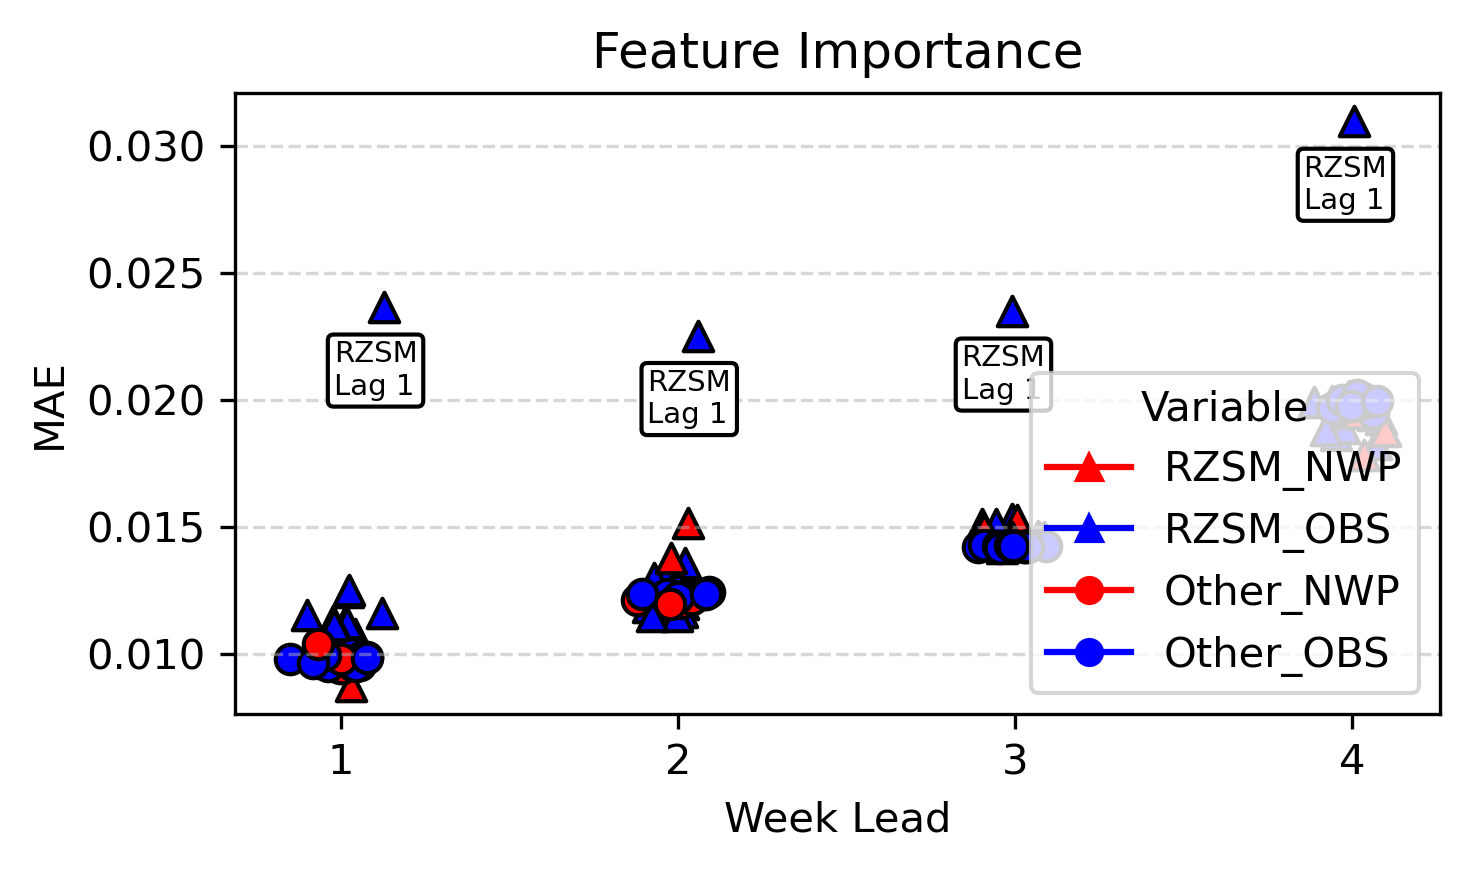

In [11]:
'''Make a shape plot'''
save_dir = f'Outputs/permutation_tests/feature_importance/{region_name}'
os.system(f'mkdir -p {save_dir}')

# Plotting
plt.figure(figsize=(5, 3),dpi=300)

for idx, row in df.iterrows():
    x = [idx] * len(row)
    
    markers = ['^' if 'RZSM' in col else 'o' for col in row.index]
    colors = ['blue' if 'obs' in col else 'red' for col in row.index]  # Blue for obs, red for non-obs
    
    for i, (x_val, y_val, marker, color) in enumerate(zip(x, row.values, markers, colors)):
        if True:  # Apply jitter only to circles
            x_val += np.random.normal(0, 0.05)  # Add jitter
        plt.scatter(x_val, y_val, marker=marker, label=idx if i == 0 else "", color=color, s=50, edgecolor='black')

        # Annotate the highest value for each week
        if y_val == max(row.values):  # Check if the current value is the maximum value for the week
            # break
            # plt.annotate(f'{row.idxmax()}', xy=(x_val, y_val), xytext=(x_val - 0.002, y_val-.002), textcoords='data', fontsize=10, color='black', ha='left', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
            plt.annotate(f'RZSM\nLag 1', xy=(x_val, y_val), xytext=(x_val - 0.15, y_val-.0025), textcoords='data', fontsize=7, color='black', ha='left', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
            

# Add legend
# plt.legend(title='Weeks', bbox_to_anchor=(1.05, 1), loc='upper left')

# Manually create legend
plt.legend(handles=[plt.Line2D([], [], marker='^', color='red', label='RZSM_NWP'),
                    plt.Line2D([], [], marker='^', color='blue', label='RZSM_OBS'),
                   plt.Line2D([], [], marker='o', color='red', label='Other_NWP'),
                   plt.Line2D([], [], marker='o', color='blue', label='Other_OBS')],
           title='Variable', loc='lower right')

# Labeling and title
plt.xlabel('Week Lead')
plt.ylabel('MAE')
plt.title('Feature Importance')
plt.xticks([1,2,3,4])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5, axis='y')  # Add grid with dashed lines and reduced opacity

# Show plot
plt.tight_layout()
plt.savefig(f'{save_dir}/variable_importance.png')
plt.show()


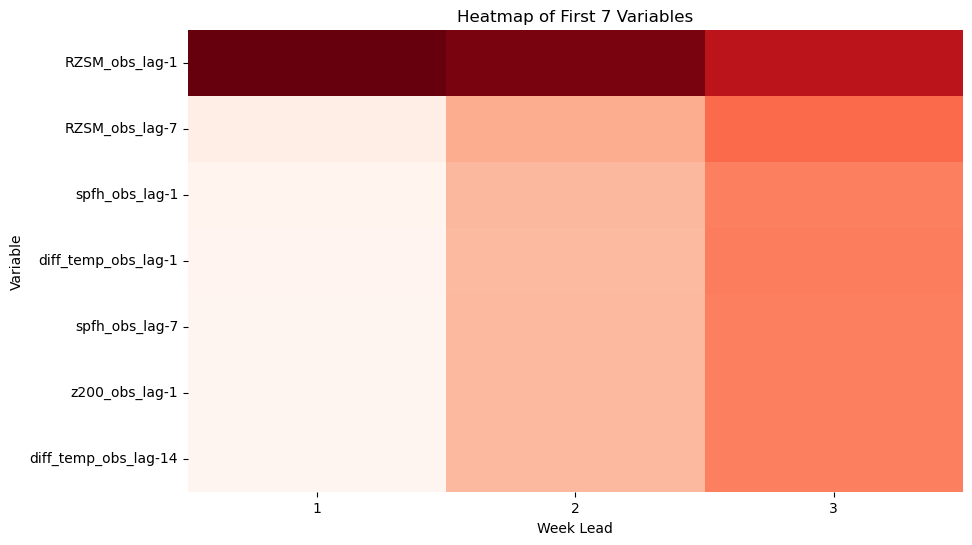

In [107]:
'''Now plot the first N top variables'''


# Create the heatmap as an image
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_first_7, annot=False, cmap='Reds', cbar=False)

# Rotate the image
# plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title('Heatmap of First 7 Variables')
plt.xlabel('Week Lead')
plt.ylabel('Variable')
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

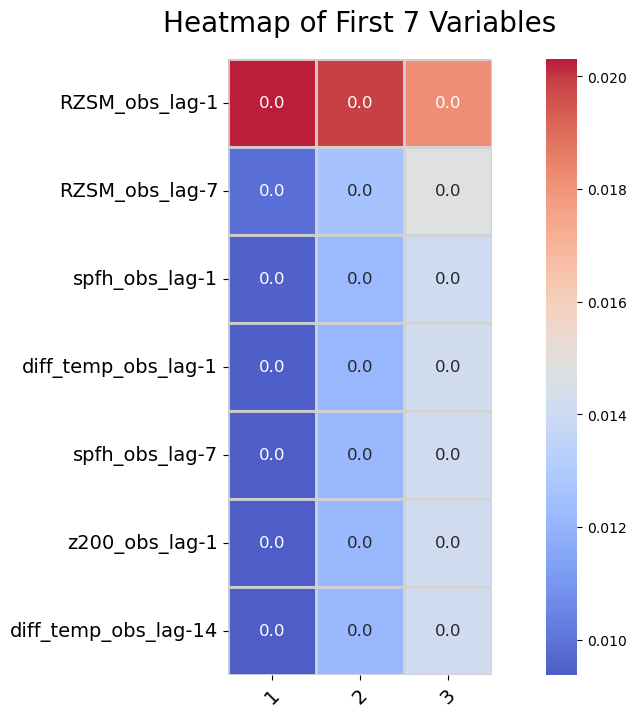

In [126]:

# Create a custom color palette
custom_palette = sns.color_palette("coolwarm", as_cmap=True)

# Create the heatmap
plt.figure(figsize=(14, 8))  # Adjust figure size
sns.heatmap(df_first_7, annot=True, cmap=custom_palette, fmt=".1f", cbar=True,
            linewidths=1, linecolor='lightgray', square=True,
            annot_kws={"size": 12}, alpha=0.9)

# Set plot title and adjust font size
plt.title('Heatmap of First 7 Variables', fontsize=20, pad=20)  # Pad adjusts title position

# Adjust tick labels font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Add colorbar label and adjust its font size
cbar = plt.colorbar()
cbar.set_label('Values', fontsize=16)

# Add border around the heatmap
plt.gca().patch.set_edgecolor('black')
plt.gca().patch.set_linewidth('2')

# Add text annotations for additional information
for i in range(df_first_7.shape[0]):
    for j in range(df_first_7.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'Var{j+1}: {df_first_7.iloc[i, j]:.1f}',
                 ha='center', va='center', color='black', fontsize=12, alpha=0.7)

# Add horizontal lines between rows for better separation
plt.axhline(y=0, color='black', linewidth=2)
for i in range(1, df_first_7.shape[0]):
    plt.axhline(y=i, color='black', linewidth=1, linestyle='--', alpha=0.5)

# Add vertical lines between columns for better separation
plt.axvline(x=0, color='black', linewidth=2)
for i in range(1, df_first_7.shape[1]):
    plt.axvline(x=i, color='black', linewidth=1, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [ ]:
#Now get a list of the unique channels

channel_names = []

for wk in week_full.keys():
    for model_type in week_full[wk].keys():
        # break
        channel_names = channel_names+ (list(week_full[wk][model_type].keys()))      

unique_names = []
for i in channel_names:
    if i not in unique_names:
        unique_names.append(i)

In [69]:
#Now make a data frame
df_hyb = pd.DataFrame(columns=[unique_names],index=range(1000))
df_obs = pd.DataFrame(columns=[unique_names],index=range(1000))

In [ ]:
for wk in week_full.keys():
    for model_type in week_full[wk].keys():

In [5]:
# Experiment info
black = ['EX0','EX13'] # bias-correction
red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25'] # obs.-driven
blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
       'EX18','EX19','EX20','EX21','EX27','EX28'] # hybrid